# Preparing data

In [2]:
import os
import numpy as np
print(os.listdir("all"))

['sample_submission.csv', 'test_images.npy', 'train_images.npy', 'train_labels.csv']


Training images:

In [3]:
#Load images with numpy
images_train = np.load('all/train_images.npy', encoding='latin1')
images_train.shape

(10000, 2)

In [4]:
X=np.concatenate(images_train[:,1],axis=0)
print(images_train.shape)
X=X.reshape(10000,10000)
print(X.shape)

(10000, 2)
(10000, 10000)


In [5]:
import pandas as pd
df = pd.read_csv('all/train_labels.csv')
df.head()
y=np.array(df.iloc[:,1])

Images for prediction:

In [6]:
#Load images with numpy
images_test = np.load('all/test_images.npy', encoding='latin1')
images_test.shape

(10000, 2)

In [7]:
X_test1=np.concatenate(images_test[:,1],axis=0)
print(images_test.shape)
X_test1=X_test1.reshape(10000,10000)
print(X_test1.shape)

(10000, 2)
(10000, 10000)


Function to center the image:

In [8]:
from scipy import ndimage
def centerimg(im):
# Determine Centre of Mass
    com = ndimage.measurements.center_of_mass(im)
    # Translation distances in x and y axis
    x_trans = int(im.shape[0]//2-com[0])
    y_trans = int(im.shape[1]//2-com[1])

    if x_trans > 0:
        im2 = np.pad(im, ((x_trans, 0), (0, 0)), mode='constant')
    else:
        im2 = np.pad(im, ((0, -x_trans), (0, 0)), mode='constant')
        im2 = im2[-x_trans:, :]

    if y_trans > 0:
        im3 = np.pad(im2, ((0, 0), (y_trans, 0)), mode='constant')
    else:
        im3 = np.pad(im2, ((0, 0), (0, -y_trans)), mode='constant')
        im3 = im3[:, -y_trans:]
    im3=im3[35:75,35:75].copy()
    return im3


Function to clean the image of noise: to do this the function take in consideration only the bigger image connected:

In [9]:
def filterimg(matrix):
    import cv2
    from sklearn import preprocessing,cross_validation,neighbors
    import numpy as np
    X_new=[]
    for i in range(0,10000):
        square = matrix[i].reshape(100,100)
        square=np.int8(square)
        image = square.astype('uint8')
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
        sizes = stats[:, -1]
        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]
        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255
        img2=centerimg(img2)
        img2=img2.reshape(-1,1600)
        X_new.append(img2)
    X_new=np.array(X_new).reshape(len(X_new),-1)
    return(X_new)

Cleaning training images:

In [10]:
X_new=filterimg(X)
print(X_new.shape)

C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(10000, 1600)


Division of training images between training and testing set: 

In [11]:
from sklearn import preprocessing,cross_validation,neighbors
import pandas as pd
#split into train and test
split = 0.2
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_new, y, test_size=split,random_state=21)

In [12]:
print(X_train.shape)
print(X_test.shape)

(8000, 1600)
(2000, 1600)


Some training images after cleaning process and division in training set: 

(40, 40)
Label1 = pillow


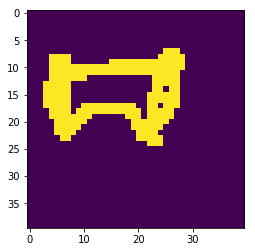

(40, 40)
Label1 = skull


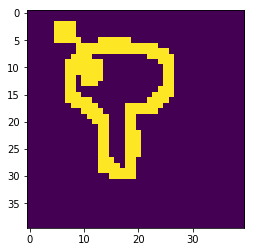

(40, 40)
Label1 = parrot


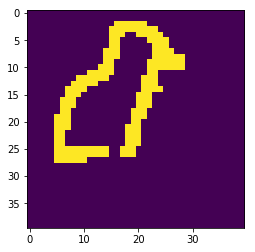

(40, 40)
Label1 = scorpion


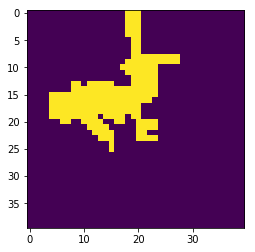

(40, 40)
Label1 = shovel


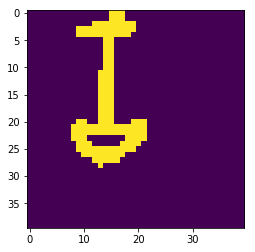

(40, 40)
Label1 = shovel


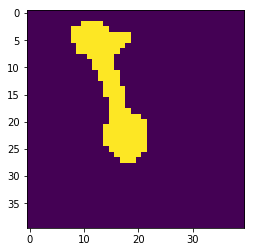

(40, 40)
Label1 = rifle


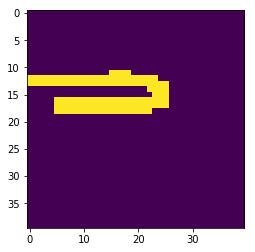

(40, 40)
Label1 = sink


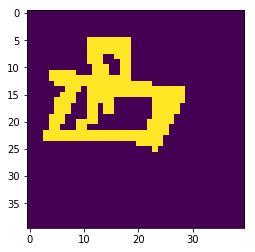

(40, 40)
Label1 = penguin


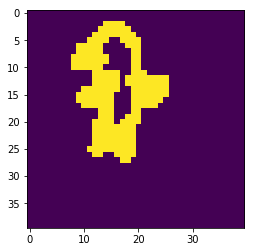

(40, 40)
Label1 = rifle


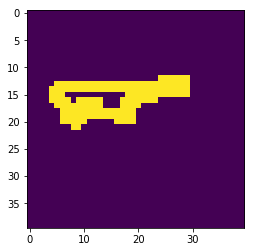

(40, 40)
Label1 = mug


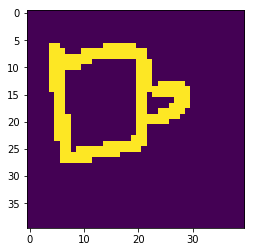

(40, 40)
Label1 = skull


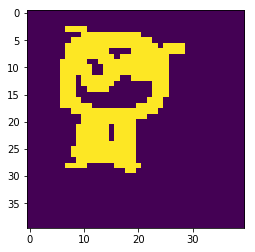

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(0,12):
    trainsetmtx = np.reshape(X_train[i], (40,40))
    print(trainsetmtx.shape)
    imgplot = plt.imshow(trainsetmtx)
    print ('Label1 = %s' % y_train[i]), plt.show()

Cleaning images used for prediction: 

In [14]:
X_test1_new=filterimg(X_test1)
print(X_test1_new.shape)

(10000, 1600)


Some images used for prediction after cleaning process and division in training set:

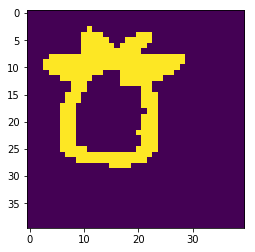

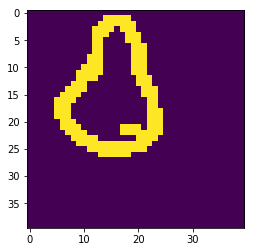

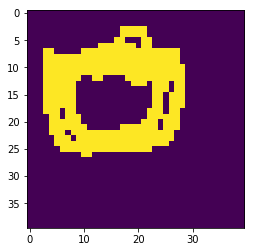

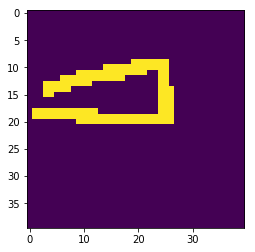

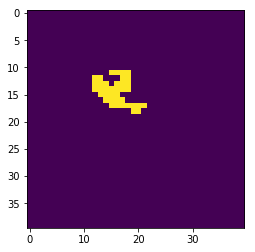

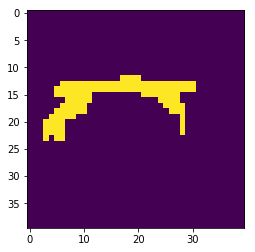

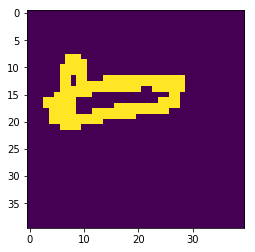

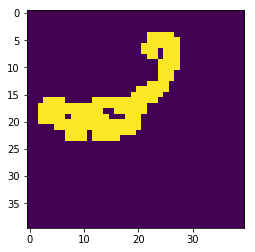

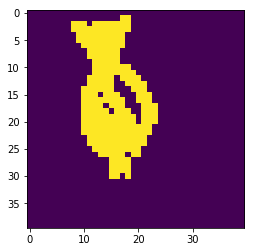

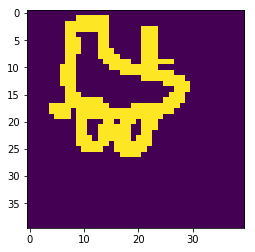

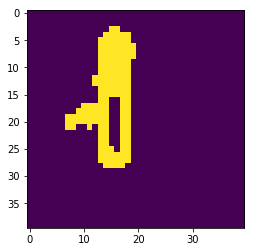

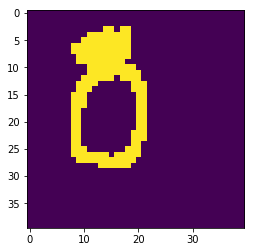

In [15]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(0,12):
    trainsetmtx = np.reshape(X_test1_new[i], (40,40))
    imgplot = plt.imshow(trainsetmtx)
    #print ('Label1 = %s' % y_train[i]), plt.show()
    plt.show()

# Implementation of Logistic Regression

In [15]:
#Training the model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# Prediction with testing sampling
y_pred = logreg.predict(X_test)

In [17]:
from sklearn import metrics
print("Accuracy:{} ".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.2325 


# Bagged decision trees
After data preparation, we're going to use Bagged Decision Trees.
We are going to test the accuracy with differents number of trees:

In [18]:
import time
import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 8
kfold = model_selection.KFold(n_splits=10)
clf = DecisionTreeClassifier()
ntrees=[100,150,200,250,280,290,300]
result=[]
t0 = time.clock()
for i in ntrees:
    model1 = BaggingClassifier(base_estimator=clf, n_estimators=i, random_state=8)
    results = model_selection.cross_val_score(model1, X_train, y_train, cv=kfold)
    print ("Time: %.4fs" % (time.clock()-t0))
    print(results.mean())
    result.append(results.mean())
print(result)

Time: 1179.2960s
0.533375
Time: 3119.5236s
0.54425
Time: 6081.6523s
0.54375
Time: 9073.3995s
0.54725
Time: 12329.4422s
0.546875
Time: 15796.7443s
0.5467500000000001
Time: 19447.5098s
0.5477500000000001
[0.533375, 0.54425, 0.54375, 0.54725, 0.546875, 0.5467500000000001, 0.5477500000000001]


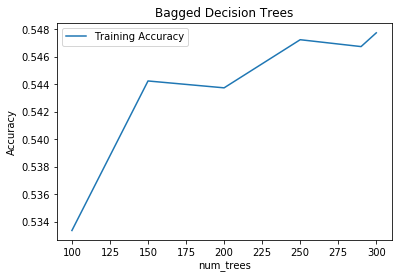

In [19]:
#Generate plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Bagged Decision Trees')
plt.plot(ntrees, result, label='Training Accuracy')
plt.legend()
plt.xlabel('num_trees')
plt.ylabel('Accuracy')
plt.show()

In [16]:
import time
import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 8
kfold = model_selection.KFold(n_splits=10)
clf = DecisionTreeClassifier()
ntrees=[600,700,800]
result=[]
t0 = time.clock()
for i in ntrees:
    model1 = BaggingClassifier(base_estimator=clf, n_estimators=i, random_state=8)
    results = model_selection.cross_val_score(model1, X_train, y_train, cv=kfold)
    print ("Time: %.4fs" % (time.clock()-t0))
    print(results.mean())
    result.append(results.mean())
print(result)

C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


Time: 6012.9795s
0.55


C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


Time: 13055.7684s
0.55075
Time: 21051.6681s
0.5509999999999999
[0.55, 0.55075, 0.5509999999999999]


C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


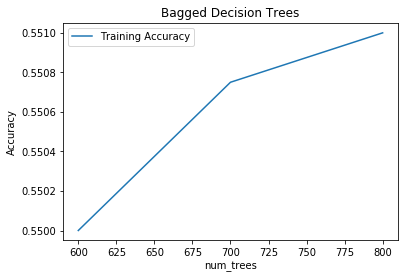

In [17]:
#Generate plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Bagged Decision Trees')
plt.plot(ntrees, result, label='Training Accuracy')
plt.legend()
plt.xlabel('num_trees')
plt.ylabel('Accuracy')
plt.show()

In [18]:
# Bagged Decision Trees for Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 7
t1 = time.clock()
kfold = model_selection.KFold(n_splits=10)
clf = DecisionTreeClassifier()
n_trees = 800
model1 = BaggingClassifier(base_estimator=clf, n_estimators=n_trees, random_state=seed)
results = model_selection.cross_val_score(model1, X_train, y_train, cv=kfold)

C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [19]:
print ("Time: %.4fs" % (time.clock()-t1))
print(results.mean())
cft1=model1.fit(X_train,y_train)
y_pred1=cft1.predict(X_test1_new)
print(y_pred1)

C:\Users\Angelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Time: 7791.6712s
0.554875
['pineapple' 'pear' 'pillow' ... 'skateboard' 'pineapple' 'mug']


In [20]:
import csv
with open('final11.csv', 'w',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id','Category'])
    for i in range(len(y_pred1)):
         spamwriter.writerow([i, y_pred1[i]])


In [23]:
# Bagged Decision Trees for Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 7
t1 = time.clock()
kfold = model_selection.KFold(n_splits=10)
clf = DecisionTreeClassifier()
n_trees = 600
model1 = BaggingClassifier(base_estimator=clf, n_estimators=n_trees, random_state=seed)
results = model_selection.cross_val_score(model1, X_train, y_train, cv=kfold)

In [ ]:
print ("Time: %.4fs" % (time.clock()-t1))
print(results.mean())
cft1=model1.fit(X_train,y_train)
y_pred1=cft1.predict(X_test1_new)
print(y_pred1)

Time: 9084.6633s
0.553625


In [27]:
import csv
with open('final10.csv', 'w',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id','Category'])
    for i in range(len(y_pred1)):
         spamwriter.writerow([i, y_pred1[i]])
